In [1]:
%pylab inline

from scipy.interpolate import interp2d

Populating the interactive namespace from numpy and matplotlib


In [2]:
class BMCycle():
    # Falta agregar el crecimiento del disco y del bulbo
    # También los cambios estructurales en el reservorio de gas caliente
    def __init__(self, R, p, e):
        cool_read = False
        
        self.R = R
        self.p = p
        self.e = e
        
        self.alpha_hot = 2.0
        self.alpha_star = -1.5
        self.epsilon_star = 0.005
        self.V_hot = 200.0
        
        self.mu = 6.02e23
        self.m_H = 1.66e-27
        self.k = 1.38e-16
        self.G = 1.0
        
        self.rho_0 = 1.0
        self.r_core = 1.0
        
        self.t = 0.0
        self.delta_t = 1e6
        self.T_gas = 1e7
        self.Z_gas = 0.0
        self.Z_cold = 0.0
        self.Z_star = 0.0
        self.r_min_0 = self.r_min(self.t)
        self.M_cold = 0.0
        self.M_cold_Z = 0.0
        self.M_hot = 1.0
        self.M_hot_Z = 0.0
        self.M_star = 0.0
        self.M_star_Z = 0.0
        self.V_disk = 0.0
        self.r_disk = 0.0
        self.beta = 1.0
        
    def tau_eff(self, V_disk, r_disk):
        return self.tau_star(V_disk, r_disk)/(1-self.R+self.beta)
    def tau_star(self, V_disk, r_disk):
        return V_disk/r_disk*(V_disk/self.V_hot)**self.alpha_star/self.epsilon_star
    
    def tau_cool(self, r, T_gas, Z_gas):
        return 3.0/2*1/(self.mu*self.m_H)*self.k*T_gas/(self.rho_gas(r)*self.Lambda_cool(T_gas,Z_gas))
    def rho_gas(self, r):
        return self.rho_0/(1+r**2/self.r_core**2)**1.5
    def Lambda_cool(self, T_gas, Z_gas):
        if not self.cool_read:
            T, Z, Lambda = loadtxt("./data/z_collis.txt", usecols=(0,14,13), unpack=True) # solar nhe/nh
            self.cool_read = True
        return griddata(T, Z, Lambda, [T_gas], [Z_gas])
    def r_ff(self, t_ff):
        return ((32.0*self.G*self.r_core**2*self.rho_0*t_ff**2/(3*pi))**(2.0/3)-self.r_core**2)**0.5
    def r_cool(self, t, T_gas, Z_gas):
        return ((3*self.k*T_gas*self.rho_0*self.r_core**2/(2*self.mu*self.m_H*self.Lambda(T_gas,Z_gas)))**(2.0/3) - \
                self.r_core**2)**0.5
    
    def r_min(self, t):
        return min(self.r_cool(t,self.T_gas,self.Z_gas),self.r_ff(t))
    def update_cycle(self, delta_t):
        self.t += delta_t
        r = linspace(self.r_min_0,self.r_min(self.t),1000)
        M_cool_dot = trapz(2*pi*r**2*self.rho_gas(r),r)/delta_t
        tau_eff = self.tau_eff(self.V_disk,self.r_disk)
        
        delta_M_acc = M_cool_dot*delta_t
        delta_M_star = self.M_cold*(1-self.R)/(1-self.R+self.beta)*(1-exp(-self.t/tau_eff)) - \
                        M_cool_dot*tau_eff*(1-self.R)/(1-self.R+self.beta)*(1-self.t/tau_eff-exp(-self.t/tau_eff))
        delta_M_cold = delta_M_acc - (1-self.R+self.beta)/(1-self.R)*delta_M_star
        delta_M_hot = -delta_M_acc + self.beta/(1-self.R)*delta_M_star
        
        delta_M_acc_Z = M_cool_dot*self.Z_gas*delta_t
        delta_M_star_Z = (1-self.R)/(1-self.R+self.beta)*(self.M_cold_Z*(1-exp(-self.t/tau_eff)) - \
                          M_cool_dot*tau_eff*self.Z_gas*(1-self.t/tau_eff-exp(-self.t/tau_eff)) + \
                          (1-self.e)*self.p/(1-self.R+self.beta)*(self.M_cold*(1 - \
                                                                        (1+self.t/tau_eff)*exp(-self.t/tau_eff)) - \
                                                                 M_cool_dot*tau_eff*(2 - self.t/tau_eff - \
                                                                (2 + self.t/tau_eff)*exp(-self.t/tau_eff))))
        delta_M_cold_Z = delta_M_acc_Z + (1-self.e)*self.p/(1-self.R)*delta_M_star - \
                         (1-self.R+self.beta)/(1-self.R)*delta_M_star_Z
        delta_M_hot_Z = -delta_M_acc_Z + self.e*self.p/(1-self.R)*delta_M_star + self.beta/(1-self.R)*delta_M_star_Z
        
        self.M_cold += delta_M_cold
        self.M_cold_Z += delta_M_cold_Z
        self.M_hot += delta_M_hot
        self.M_hot_Z += delta_M_hot_Z
        self.M_star += delta_M_star
        self.M_star_Z += delta_M_star_Z
        
        self.Z_cold = self.M_cold_Z/self.M_cold
        self.Z_gas = self.M_hot_Z/self.M_hot
        self.Z_star = self.M_star_Z/self.M_star
        
        self.t += delta_t

In [3]:
# column 1: T [K] 
# column 2: Lambda/n_H^2 [erg s-1 cm^3] (nhe/nh = 0.0786528)
# column 3: ne/nh (nhe/nh = 0.0786528)
# column 4: Lambda/n_H^2 [erg s-1 cm^3] (nhe/nh = 0.0830474)
# column 5: ne/nh (nhe/nh = 0.0830474)
# column 6: Lambda/n_H^2 [erg s-1 cm^3] (nhe/nh = 0.0875605)
# column 7: ne/nh (nhe/nh = 0.0875605)
# column 8: Lambda/n_H^2 [erg s-1 cm^3] (nhe/nh = 0.0921968)
# column 9: ne/nh (nhe/nh = 0.0921968)
# column 10: Lambda/n_H^2 [erg s-1 cm^3] (nhe/nh = 0.0969616)
# column 11: ne/nh (nhe/nh = 0.0969616)
# column 12: Lambda/n_H^2 [erg s-1 cm^3] (nhe/nh = 0.10186)
# column 13: ne/nh (nhe/nh = 0.10186)
# column 14: Lambda/n_H^2 [erg s-1 cm^3] (nhe/nh = 0.106898)
# column 15: ne/nh (nhe/nh = 0.106898)
# column 16: Lambda/n_H^2 [erg s-1 cm^3] (metals only)
# column 17: Lambda/n_H^2 [erg s-1 cm^3] (C only)
# column 18: Lambda/n_H^2 [erg s-1 cm^3] (N only)
# column 19: Lambda/n_H^2 [erg s-1 cm^3] (O only)
# column 20: Lambda/n_H^2 [erg s-1 cm^3] (Ne only)
# column 21: Lambda/n_H^2 [erg s-1 cm^3] (Mg only)
# column 22  Lambda/n_H^2 [erg s-1 cm^3] (Si only)
# column 23  Lambda/n_H^2 [erg s-1 cm^3] (S only)
# column 24  Lambda/n_H^2 [erg s-1 cm^3] (Ca only)
# column 25  Lambda/n_H^2 [erg s-1 cm^3] (Fe only)

t = loadtxt("data/z_collis.txt")

nhe_nh = array([[0.079, 0.083, 0.088, 0.092, 0.097, 0.102, 0.107]]).repeat(t.shape[0], axis=0)
T = t[:,0]
Z = t[:,[2,4,6,8,10,12,14]]/(1.0+nhe_nh+t[:,[2,4,6,8,10,12,14]])
Lambda = t[:,[1,3,5,7,9,11,13]]

Sigma_cold_ = 4.0 # M_sun pc^-2    Leroy+2013
T_hot_ = 1e7      # K              Wiersma+2009
rho_hot_ = 1e-3   # cm^-3          Wiersma+2009
Z_hot_ = 0.017    #                Wiersma+2009
Lambda_ = 1e-23   # erg cm^-3 s^-1 Wiersma+2009

In [4]:
rc("text", usetex=False)
rc("font", size=16)
rc("xtick", labelsize="small")
rc("ytick", labelsize="small")
rc("axes", labelsize="large")

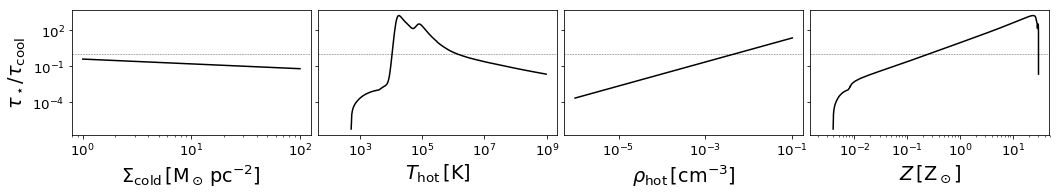

In [6]:
Sigma_cold = linspace(1,100,1000)
T_hot = T
rho_hot = linspace(1e-6,1e-1,1000)
Z_hot = Z[:,6]/0.017

t_sigma = 0.4*(Sigma_cold)**(-0.4)*(1e7/T_hot_)*(rho_hot_/1e-3)*(Lambda_/1e-23)
t_T_hot = 0.4*(Sigma_cold_)**(-0.4)*(1e7/T_hot)*(rho_hot_/1e-3)*(Lambda[:,6]/1e-23)
t_rho_hot = 0.4*(Sigma_cold_)**(-0.4)*(1e7/T_hot_)*(rho_hot/1e-3)*(Lambda_/1e-23)
t_Z_hot = 0.4*(Sigma_cold_)**(-0.4)*(1e7/T_hot)*(rho_hot_/1e-3)*(Lambda[:,6]/1e-23)

xs = Sigma_cold, T_hot, rho_hot, Z_hot
ys = t_sigma, t_T_hot, t_rho_hot, t_Z_hot
lb = (
    r"$\Sigma_{\rm cold}\,[{\rm M}_\odot\,{\rm pc}^{-2}]$",
    r"$T_{\rm hot}\,[{\rm K}]$",
    r"$\rho_{\rm hot}\,[{\rm cm}^{-3}]$",
    r"$Z\,[{\rm Z}_\odot]$"
)

fig, axs = subplots(1, 4, figsize=(15,3), sharey=True)

axs[0].set_ylabel(r"$\tau_\star/\tau_{\rm cool}$")

for i in xrange(axs.size):
    axs[i].axhline(1.0, ls="--", lw=0.5, color="0.4")
    axs[i].loglog(xs[i], ys[i], "-k", lw=1.5)
    
    axs[i].set_xlabel(lb[i])

fig.tight_layout()
fig.subplots_adjust(wspace=0.03)